In [4]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

In [52]:
test_folder = "test-set"

def inference(image_number):
  #forward prop
  image_path = f"{test_folder}/img{image_number}.png"
  image = Image.open(image_path).resize((1080, 1080))

  # convert image to RGB
  image = image.convert('RGB')

  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)


  #predicted semantic segmentation
  upsampled_logits = torch.nn.functional.interpolate(
      logits,
      size=image.size[::-1], # (height, width)
      mode='bilinear',
      align_corners=False
  )
  pred_seg = upsampled_logits.argmax(dim=1)[0]

  # load ground truth segmentation mask
  gt_path = f"{test_folder}/label{image_number}.png"
  gt_mask = Image.open(gt_path).resize((1080, 1080))
  gt_mask = np.array(gt_mask)


  #convert 9->2 and 8->1, all else becomes 0
  pred_converted_mask = np.zeros_like(pred_seg)

  # Convert values: 9 (terrain) ->2, 8 (tree) ->1, all else 0
  pred_converted_mask[pred_seg == 9] = 1
  pred_converted_mask[pred_seg == 8] = 2


  # confusion matrix metrics for both classes
  # Metrics for background (class 0)
  tp_bg = np.sum((pred_converted_mask == gt_mask) & (gt_mask == 0))
  fp_bg = np.sum((pred_converted_mask == 0) & (gt_mask != 0))
  tn_bg = np.sum((pred_converted_mask != 0) & (gt_mask != 0))
  fn_bg = np.sum((pred_converted_mask != 0) & (gt_mask == 0))

  # Metrics for terrain (class 1)
  tp_terrain = np.sum((pred_converted_mask == gt_mask) & (gt_mask == 1))
  fp_terrain = np.sum((pred_converted_mask == 1) & (gt_mask != 1))
  tn_terrain = np.sum((pred_converted_mask != 1) & (gt_mask != 1))
  fn_terrain = np.sum((pred_converted_mask != 1) & (gt_mask == 1))

  # Metrics for trees (class 2)
  tp_trees = np.sum((pred_converted_mask == gt_mask) & (gt_mask == 2))
  fp_trees = np.sum((pred_converted_mask == 2) & (gt_mask != 2))
  tn_trees = np.sum((pred_converted_mask != 2) & (gt_mask != 2))
  fn_trees = np.sum((pred_converted_mask != 2) & (gt_mask == 2))


  print(f"Background Metrics:")
  print(f"True Positives: {tp_bg}")
  print(f"False Positives: {fp_bg}")
  print(f"True Negatives: {tn_bg}")
  print(f"False Negatives: {fn_bg}")
  print(f"\nTerrain Metrics:")
  print(f"True Positives: {tp_terrain}")
  print(f"False Positives: {fp_terrain}")
  print(f"True Negatives: {tn_terrain}") 
  print(f"False Negatives: {fn_terrain}")
  print(f"\nTrees Metrics:")
  print(f"True Positives: {tp_trees}")
  print(f"False Positives: {fp_trees}")
  print(f"True Negatives: {tn_trees}")
  print(f"False Negatives: {fn_trees}")


  # Display original image, prediction and ground truth
  plt.figure(figsize=(20,5))

  plt.subplot(1,4,1)
  plt.imshow(image)
  plt.title('Original Image')
  plt.axis('off')


  plt.subplot(1,4,2)
  plt.imshow(pred_seg.cpu().numpy())
  plt.title('Predicted Segmentation')
  plt.axis('off')


  plt.subplot(1,4,3)
  plt.imshow(pred_converted_mask)
  plt.title('Predicted Segmentation (Tree and Terrain)')
  plt.axis('off')


  plt.subplot(1,4,4)
  plt.imshow(gt_mask)
  plt.title('Ground Truth (Tree and Terrain)')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

  return tp_bg, fp_bg, tn_bg, fn_bg, tp_terrain, fp_terrain, tn_terrain, fn_terrain, tp_trees, fp_trees, tn_trees, fn_trees

Background Metrics:
True Positives: 963696
False Positives: 15086
True Negatives: 175025
False Negatives: 12593

Terrain Metrics:
True Positives: 34060
False Positives: 3729
True Negatives: 1126629
False Negatives: 1982

Trees Metrics:
True Positives: 140958
False Positives: 8871
True Negatives: 1003460
False Negatives: 13111


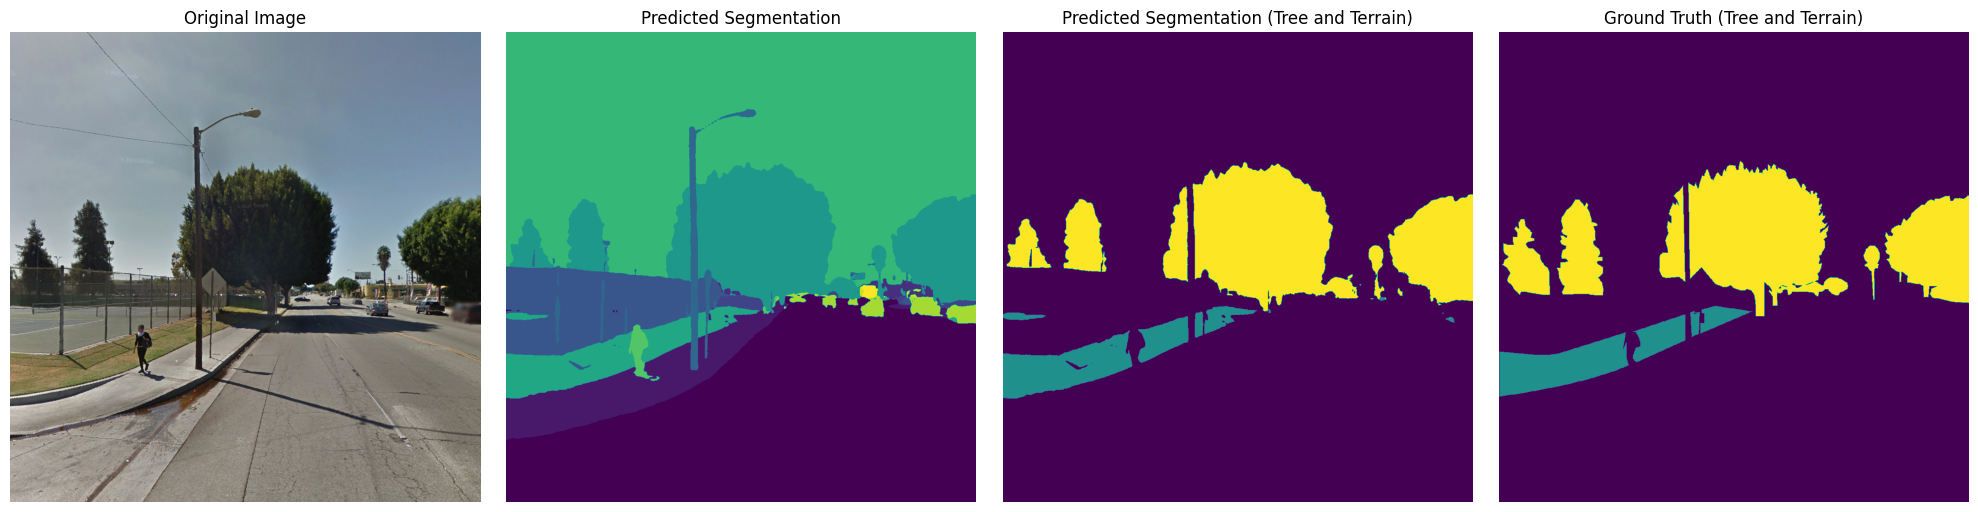

Background Metrics:
True Positives: 902809
False Positives: 11076
True Negatives: 235344
False Negatives: 17171

Terrain Metrics:
True Positives: 6387
False Positives: 1556
True Negatives: 1154936
False Negatives: 3521

Trees Metrics:
True Positives: 228733
False Positives: 15839
True Negatives: 914049
False Negatives: 7779


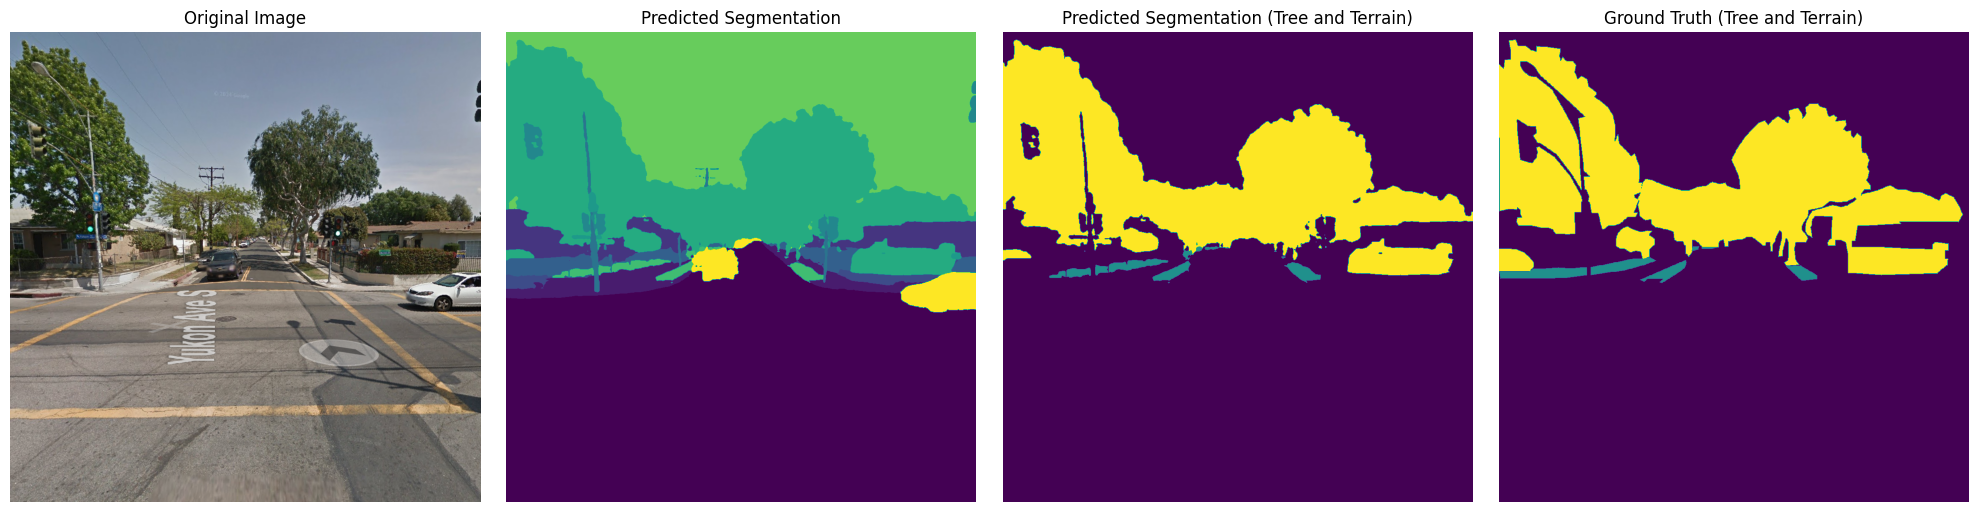

In [54]:
tp0 = fp0 = tn0 = fn0 = tp1 = fp1 = tn1 = fn1 = tp2 = fp2 = tn2 = fn2 = 0

for i in range(1,3):
  tp0i, fp0i, tn0i, fn0i, tp1i, fp1i, tn1i, fn1i, tp2i, fp2i, tn2i, fn2i = inference(i)
  tp0 += tp0i
  fp0 += fp0i
  tn0 += tn0i
  fn0 += fn0i
  tp1 += tp1i
  fp1 += fp1i
  tn1 += tn1i
  fn1 += fn1i
  tp2 += tp2i
  fp2 += fp2i
  tn2 += tn2i
  fn2 += fn2i

In [59]:
# Calculate accuracy for each class
acc_bg = (tp0 + tn0) / (tp0 + tn0 + fp0 + fn0)
acc_terrain = (tp1 + tn1) / (tp1 + tn1 + fp1 + fn1) 
acc_trees = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)

# Calculate overall accuracy
overall_acc = (tp0 + tp1 + tp2 + tn0 + tn1 + tn2) / (tp0 + tn0 + fp0 + fn0 + tp1 + tn1 + fp1 + fn1 + tp2 + tn2 + fp2 + fn2)

# Calculate IoU for each class
iou_bg = tp0 / (tp0 + fp0 + fn0)
iou_terrain = tp1 / (tp1 + fp1 + fn1)
iou_trees = tp2 / (tp2 + fp2 + fn2)

# Calculate mean IoU
mean_iou = (iou_bg + iou_terrain + iou_trees) / 3

# Calculate class weights based on pixel frequencies
total_pixels = tp0 + fn0 + tp1 + fn1 + tp2 + fn2
weight_bg = (tp0 + fn0) / total_pixels
weight_terrain = (tp1 + fn1) / total_pixels
weight_trees = (tp2 + fn2) / total_pixels

# Calculate weighted mean IoU
weighted_mean_iou = iou_bg * weight_bg + iou_terrain * weight_terrain + iou_trees * weight_trees

print(f"Overall Accuracy: {overall_acc:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Weighted Mean IoU: {weighted_mean_iou:.4f}")

print("\nPer-class metrics:")
print(f"Background - Accuracy: {acc_bg:.4f}, IoU: {iou_bg:.4f}")
print(f"Terrain - Accuracy: {acc_terrain:.4f}, IoU: {iou_terrain:.4f}")
print(f"Trees - Accuracy: {acc_trees:.4f}, IoU: {iou_trees:.4f}")


Overall Accuracy: 0.9840
Mean IoU: 0.8835
Weighted Mean IoU: 0.9538

Per-class metrics:
Background - Accuracy: 0.9760, IoU: 0.9709
Terrain - Accuracy: 0.9954, IoU: 0.7894
Trees - Accuracy: 0.9805, IoU: 0.8902
